# https://scib-metrics.readthedocs.io/en/latest/notebooks/lung_example.html

In [1]:
import sys
print(sys.version)
print(sys.executable)
import importlib
print(importlib.util.find_spec("scbiot"))
import scbiot as scb


3.12.8 (main, Jan 14 2025, 22:49:14) [Clang 19.1.6 ]
/home/figo/software/python_libs/scbiot/.venv/bin/python
ModuleSpec(name='scbiot', loader=<_frozen_importlib_external.SourceFileLoader object at 0x778f4365daf0>, origin='/home/figo/software/python_libs/scbiot/src/scbiot/__init__.py', submodule_search_locations=['/home/figo/software/python_libs/scbiot/src/scbiot'])


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import seaborn as sns
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
import torch
import os
import pandas as pd
import scbiot as scb
from scbiot.utils import set_seed

import harmonypy as hm
from umap import UMAP
# %pip install scib-metrics
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

set_seed(42)

from pathlib import Path
dir = Path.cwd()
print(dir)
parent_dir = dir.parent
print(parent_dir)


Random seed set as 42
/home/figo/software/python_libs/scbiot/examples
/home/figo/software/python_libs/scbiot


In [3]:
adata_path = f"{dir}/inputs/lung_atlas.h5ad"

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
# ==== Make semi-supervised labels from true labels ====
# deps: numpy, pandas (AnnData in memory as `adata`)
import numpy as np
import pandas as pd

def make_semi_labels(
    adata,
    label_key="cell_type",
    out_key="semi_cell_type",
    unlabeled_tag="Unknown",
    frac_unlabeled=0.8,     # fraction to hide per class
    min_keep=20,            # keep at least this many labeled per class
    batch_key=None,         # e.g., "batch"; set None to ignore batch
    seed=42,
    protect_classes=None,   # list of classes to never mask
):
    """
    Create `out_key` by masking a fraction of cells to `unlabeled_tag`.
    - Works per class (or per (batch,class) if batch_key is given).
    - Ensures at least `min_keep` labeled remain per class group.
    """
    rng = np.random.default_rng(seed)

    # base labels as string; fill NAs with unlabeled_tag
    true_lab = adata.obs[label_key].astype("string").fillna(unlabeled_tag)

    # prepare output (start as a copy of true labels)
    semi = true_lab.copy()

    # ensure category list preserves originals + unlabeled_tag
    cats = list(pd.Categorical(adata.obs[label_key]).categories) \
           if pd.api.types.is_categorical_dtype(adata.obs[label_key]) \
           else sorted(pd.unique(true_lab))
    if unlabeled_tag not in cats:
        cats.append(unlabeled_tag)

    protect = set(protect_classes or [])

    def _mask_group(idx):
        # idx: numpy array of row indices for this (batch,class) group
        n = len(idx)
        if n == 0:
            return
        # how many to keep labeled
        keep_n = max(min_keep, int(round((1.0 - frac_unlabeled) * n)))
        keep_n = min(keep_n, n)
        # choose which to keep; mask the rest
        if keep_n < n:
            keep_idx = rng.choice(idx, size=keep_n, replace=False)
            mask_idx = np.setdiff1d(idx, keep_idx, assume_unique=False)
            semi.iloc[mask_idx] = unlabeled_tag

    if batch_key is None:
        # per-class masking
        for cls, idx in adata.obs.groupby(label_key).indices.items():
            if cls in protect or cls == unlabeled_tag:
                continue
            _mask_group(np.fromiter(idx, dtype=int))
    else:
        # stratify by (batch, class)
        for (b, cls), idx in adata.obs.groupby([batch_key, label_key]).indices.items():
            if cls in protect or cls == unlabeled_tag:
                continue
            _mask_group(np.fromiter(idx, dtype=int))

    # assign as categorical
    adata.obs[out_key] = pd.Categorical(semi, categories=cats)

    # quick summary
    before = pd.Series(true_lab).value_counts().sort_index()
    after  = pd.Series(adata.obs[out_key].astype(str)).value_counts().sort_index()
    print("\n=== Per-class counts (before -> after, including 'Unknown') ===")
    print(pd.DataFrame({"before": before, "after": after}).fillna(0).astype(int))

# ---------- usage ----------
# simplest (mask ~80% per class, keep ≥20 labeled each):
make_semi_labels(adata, label_key="cell_type", out_key="semi_cell_type")

# examples:
# - Stratify by batch: make_semi_labels(adata, batch_key="batch")
# - Keep small classes intact: make_semi_labels(adata, protect_classes=["rare_type"])
# - Be gentler (only hide 50%): make_semi_labels(adata, frac_unlabeled=0.5)
# - For tiny datasets, lower min_keep: make_semi_labels(adata, min_keep=5)



=== Per-class counts (before -> after, including 'Unknown') ===
                      before  after
B cell                  1353    271
Basal 1                 1972    394
Basal 2                 3072    614
Ciliated                3155    631
Dendritic cell          1367    273
Endothelium              988    198
Fibroblast               733    147
Ionocytes                 46     20
Lymphatic                341     68
Macrophage              7492   1498
Mast cell                889    178
Neutrophil_CD14_high    1626    325
Neutrophils_IL1R2        472     94
Secretory               2459    492
T/NK cell               1797    359
Type 1                   424     85
Type 2                  4286    857
Unknown                    0  25968


In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key='batch')
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

# sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", batch_key='batch')
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# sc.pp.scale(adata)
# sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [6]:
adata, metrics = scb.ot.integrate(adata, modality='supervised', obsm_key='X_pca', batch_key='batch', out_key='X_ot',
                                  true_label_key="semi_cell_type",
                                  # OT
    K_ref=1024, K_batch=448, reg=0.03, reg_m=0.40,
    # Connectivity (relaxed)
    sharpen=0.15, K_pseudo=24, pull=0.75, push=0.30,
    lambda0_hi=0.50, lambda0_lo=0.35,
    smin_bulk=0.75, smax_bulk=1.65,
    smin_bridge=0.85, smax_bridge=1.25,
    max_step_local=1.0,
    step_lo=0.75, step_hi=0.95,
    q_start=0.80, q_end=0.90,
    overlap0_lo=0.60, overlap0_hi=0.70,
    w_overlap=0.20, w_strain=1.0, penalty_gamma=1.5,
    # --- supervised ---    
    lam_sup=0.60,
    lam_repulse=0.18,
    use_gpu=True, ot_backend="torch", verbose=True)
                                  
print(metrics)

[baseline] KNN backend=FAISS-GPU mix=0.5343 strain=0.00000
[iter 01] mix=0.583 overlap0=0.834 strain=0.00470 floor~0.600 J=0.137 best_it=1
[iter 02] mix=0.633 overlap0=0.727 strain=0.01457 floor~0.607 J=0.181 best_it=2
[iter 03] mix=0.670 overlap0=0.665 strain=0.02663 floor~0.613 J=0.213 best_it=3
[iter 04] mix=0.698 overlap0=0.622 strain=0.03851 floor~0.620 J=0.230 best_it=4
[iter 05] mix=0.718 overlap0=0.582 strain=0.05009 floor~0.627 J=0.229 best_it=4
[iter 06] mix=0.718 overlap0=0.580 strain=0.05028 floor~0.633 J=0.227 best_it=4
[iter 07] mix=0.719 overlap0=0.584 strain=0.05059 floor~0.640 J=0.229 best_it=4
[early stop] plateau reached.
[final] it*=4 mix=0.698 overlap0=0.622 strain=0.03851 tw=0.991
{'mix': 0.6975705061070518, 'overlap0': 0.6218400597572327, 'strain': 0.03851358965039253, 'tw': 0.9906567691994296, 'it': 4}


In [7]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'semi_cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca', 'X_ot'
    varm: 'PCs'
    layers: 'counts'

In [8]:
# 1. Compute neighbors using Harmony-corrected PCA
sc.pp.neighbors(adata, use_rep='X_ot')

# 2. Run UMAP 
sc.tl.umap(adata)

# 3. Leiden clustering
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_X_ot')
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'semi_cell_type', 'n_counts', 'leiden_X_ot'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_X_ot'
    obsm: 'X_pca', 'X_ot', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [9]:
adata.obs['leiden_X_ot'].value_counts()

leiden_X_ot
0     2657
1     2640
2     2089
3     1980
4     1943
5     1886
6     1833
7     1798
8     1595
9     1505
10    1402
11    1327
12    1323
13    1278
14    1208
15     856
16     856
17     731
18     721
19     543
20     490
21     469
22     464
23     447
24     332
25      58
26      41
Name: count, dtype: int64

In [10]:
from sklearn.metrics import normalized_mutual_info_score

df = pd.DataFrame(adata.obsm['X_ot'], index=adata.obs.index) # adata.X.toarray()
df['batch'] = adata.obs['batch']

df['target'] = adata.obs['cell_type']
# Step 1: Get the counts of each category
category_counts = df['target'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['target'] = df['target'].map(category_mapping)

df['pseudo'] = adata.obs['leiden_X_ot']
# Step 1: Get the counts of each category
category_counts = df['pseudo'].value_counts()
# Step 2: Create a mapping of categories to numbers based on descending counts
category_mapping = {category: idx for idx, category in enumerate(category_counts.index)}
# Step 3: Map the original categorical column to the new numeric values
df['pseudo'] = df['pseudo'].map(category_mapping)

df = df.reset_index().set_index(['index', 'batch', 'target', 'pseudo'])

# Extract numeric labels
true_labels = df.reset_index()['target']
pred_labels = df.reset_index()['pseudo']

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
print("NMI:", nmi_score)


NMI: 0.778816618961243


In [11]:
# adata.write_h5ad(f'{dir}/cluster/lung/alldata.h5ad')

In [12]:
scb.pp.setup_anndata(adata, var_key='X_ot', batch_key='batch', pseudo_key='leiden_X_ot', true_key=None)

{'var_key': 'X_ot',
 'batch_key': 'batch',
 'pseudo_key': 'leiden_X_ot',
 'true_key': None}

In [13]:
model = scb.models.vae(adata, verbose=True)

Random seed set as 42
[Explicit labels] has_pseudo=True
[Explicit labels] batch_train/test: torch.Size([29224]) / torch.Size([3248])
[Explicit labels] pseudo_train/test: torch.Size([29224]) / torch.Size([3248])


In [14]:
model.train()

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Saved whole dataset latents (N=32472)


Training:   1%|▏         | 1/80 [00:03<04:47,  3.63s/it, epoch=1/80, Train_loss=1.9701, Test_loss=1.7606]

{'Train NMI': 0.259, 'Train ARI': 0.125, 'Train ACC': 0.207, 'Train kBET': 0.893, 'Train CCR': 0.0}


Training:   2%|▎         | 2/80 [00:05<03:09,  2.43s/it, epoch=2/80, Train_loss=2.7357, Test_loss=2.4460]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.321, 'Train ARI': 0.166, 'Train ACC': 0.261, 'Train kBET': 0.862, 'Train CCR': 0.0}


Training:   4%|▍         | 3/80 [00:06<02:35,  2.02s/it, epoch=3/80, Train_loss=3.1745, Test_loss=2.9335]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.467, 'Train ARI': 0.28, 'Train ACC': 0.298, 'Train kBET': 0.75, 'Train CCR': 0.0}


Training:   5%|▌         | 4/80 [00:08<02:28,  1.95s/it, epoch=4/80, Train_loss=3.5818, Test_loss=3.5371]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.557, 'Train ARI': 0.331, 'Train ACC': 0.358, 'Train kBET': 0.581, 'Train CCR': 0.0}


Training:   6%|▋         | 5/80 [00:10<02:13,  1.78s/it, epoch=5/80, Train_loss=4.0900, Test_loss=3.8574]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.611, 'Train ARI': 0.389, 'Train ACC': 0.384, 'Train kBET': 0.388, 'Train CCR': 0.366}


Training:   8%|▊         | 6/80 [00:11<02:04,  1.68s/it, epoch=6/80, Train_loss=4.2332, Test_loss=3.9198]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.663, 'Train ARI': 0.432, 'Train ACC': 0.413, 'Train kBET': 0.285, 'Train CCR': 8.003}


Training:   9%|▉         | 7/80 [00:13<02:01,  1.67s/it, epoch=7/80, Train_loss=3.8692, Test_loss=3.6215]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.669, 'Train ARI': 0.432, 'Train ACC': 0.401, 'Train kBET': 0.254, 'Train CCR': 21.386}


Training:  10%|█         | 8/80 [00:14<02:01,  1.69s/it, epoch=8/80, Train_loss=3.5723, Test_loss=3.4130]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.706, 'Train ARI': 0.487, 'Train ACC': 0.384, 'Train kBET': 0.244, 'Train CCR': 28.722}


Training:  11%|█▏        | 9/80 [00:16<01:48,  1.53s/it, epoch=9/80, Train_loss=3.3726, Test_loss=3.2225]

{'Train NMI': 0.693, 'Train ARI': 0.472, 'Train ACC': 0.385, 'Train kBET': 0.24, 'Train CCR': 34.66}


Training:  12%|█▎        | 10/80 [00:17<01:44,  1.50s/it, epoch=10/80, Train_loss=3.1305, Test_loss=3.0106]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.723, 'Train ARI': 0.496, 'Train ACC': 0.453, 'Train kBET': 0.228, 'Train CCR': 42.728}


Training:  14%|█▍        | 11/80 [00:19<01:45,  1.53s/it, epoch=11/80, Train_loss=2.9148, Test_loss=2.8315]

{'Train NMI': 0.72, 'Train ARI': 0.499, 'Train ACC': 0.416, 'Train kBET': 0.234, 'Train CCR': 46.751}


Training:  15%|█▌        | 12/80 [00:20<01:47,  1.59s/it, epoch=12/80, Train_loss=2.7395, Test_loss=2.6903]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.734, 'Train ARI': 0.524, 'Train ACC': 0.433, 'Train kBET': 0.225, 'Train CCR': 52.582}


Training:  16%|█▋        | 13/80 [00:22<01:44,  1.56s/it, epoch=13/80, Train_loss=2.6111, Test_loss=2.5727]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.742, 'Train ARI': 0.544, 'Train ACC': 0.453, 'Train kBET': 0.227, 'Train CCR': 57.702}


Training:  18%|█▊        | 14/80 [00:23<01:34,  1.43s/it, epoch=14/80, Train_loss=2.4956, Test_loss=2.4793]

{'Train NMI': 0.739, 'Train ARI': 0.54, 'Train ACC': 0.495, 'Train kBET': 0.215, 'Train CCR': 56.239}


Training:  19%|█▉        | 15/80 [00:24<01:34,  1.45s/it, epoch=15/80, Train_loss=2.4139, Test_loss=2.4047]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.745, 'Train ARI': 0.51, 'Train ACC': 0.425, 'Train kBET': 0.224, 'Train CCR': 61.059}


Training:  20%|██        | 16/80 [00:26<01:32,  1.45s/it, epoch=16/80, Train_loss=2.3615, Test_loss=2.5840]

{'Train NMI': 0.744, 'Train ARI': 0.555, 'Train ACC': 0.455, 'Train kBET': 0.212, 'Train CCR': 63.016}


Training:  21%|██▏       | 17/80 [00:27<01:31,  1.46s/it, epoch=17/80, Train_loss=2.3851, Test_loss=2.3973]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.756, 'Train ARI': 0.566, 'Train ACC': 0.524, 'Train kBET': 0.209, 'Train CCR': 67.212}


Training:  22%|██▎       | 18/80 [00:29<01:25,  1.38s/it, epoch=18/80, Train_loss=2.3092, Test_loss=2.2890]

{'Train NMI': 0.745, 'Train ARI': 0.552, 'Train ACC': 0.418, 'Train kBET': 0.206, 'Train CCR': 69.707}


Training:  24%|██▍       | 19/80 [00:30<01:26,  1.42s/it, epoch=19/80, Train_loss=2.2395, Test_loss=2.2516]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.761, 'Train ARI': 0.577, 'Train ACC': 0.487, 'Train kBET': 0.209, 'Train CCR': 75.516}


Training:  25%|██▌       | 20/80 [00:31<01:20,  1.34s/it, epoch=20/80, Train_loss=2.1946, Test_loss=2.2264]

{'Train NMI': 0.751, 'Train ARI': 0.541, 'Train ACC': 0.472, 'Train kBET': 0.205, 'Train CCR': 75.796}


Training:  26%|██▋       | 21/80 [00:33<01:22,  1.40s/it, epoch=21/80, Train_loss=2.1740, Test_loss=2.1898]

{'Train NMI': 0.746, 'Train ARI': 0.521, 'Train ACC': 0.441, 'Train kBET': 0.206, 'Train CCR': 71.945}


Training:  28%|██▊       | 22/80 [00:34<01:25,  1.47s/it, epoch=22/80, Train_loss=2.1513, Test_loss=2.1822]

{'Train NMI': 0.759, 'Train ARI': 0.573, 'Train ACC': 0.501, 'Train kBET': 0.205, 'Train CCR': 79.454}


Training:  29%|██▉       | 23/80 [00:36<01:19,  1.39s/it, epoch=23/80, Train_loss=2.1234, Test_loss=2.1580]

{'Train NMI': 0.753, 'Train ARI': 0.554, 'Train ACC': 0.445, 'Train kBET': 0.198, 'Train CCR': 76.7}


Training:  30%|███       | 24/80 [00:37<01:14,  1.32s/it, epoch=24/80, Train_loss=2.1126, Test_loss=2.1487]

{'Train NMI': 0.745, 'Train ARI': 0.521, 'Train ACC': 0.469, 'Train kBET': 0.209, 'Train CCR': 77.13}


Training:  31%|███▏      | 25/80 [00:38<01:14,  1.36s/it, epoch=25/80, Train_loss=2.0953, Test_loss=2.1359]

{'Train NMI': 0.759, 'Train ARI': 0.566, 'Train ACC': 0.503, 'Train kBET': 0.203, 'Train CCR': 82.939}


Training:  32%|███▎      | 26/80 [00:39<01:09,  1.30s/it, epoch=26/80, Train_loss=2.0857, Test_loss=2.1295]

{'Train NMI': 0.757, 'Train ARI': 0.539, 'Train ACC': 0.432, 'Train kBET': 0.203, 'Train CCR': 85.564}


Training:  34%|███▍      | 27/80 [00:41<01:07,  1.27s/it, epoch=27/80, Train_loss=2.0898, Test_loss=2.1223]

{'Train NMI': 0.746, 'Train ARI': 0.546, 'Train ACC': 0.459, 'Train kBET': 0.204, 'Train CCR': 80.551}


Training:  35%|███▌      | 28/80 [00:42<01:04,  1.24s/it, epoch=28/80, Train_loss=2.0748, Test_loss=2.1154]

{'Train NMI': 0.744, 'Train ARI': 0.522, 'Train ACC': 0.414, 'Train kBET': 0.202, 'Train CCR': 81.519}


Training:  36%|███▋      | 29/80 [00:43<01:07,  1.32s/it, epoch=29/80, Train_loss=2.0775, Test_loss=2.1146]

{'Train NMI': 0.756, 'Train ARI': 0.562, 'Train ACC': 0.442, 'Train kBET': 0.204, 'Train CCR': 77.991}


Training:  38%|███▊      | 30/80 [00:44<01:03,  1.27s/it, epoch=30/80, Train_loss=2.0706, Test_loss=2.1061]

{'Train NMI': 0.76, 'Train ARI': 0.562, 'Train ACC': 0.506, 'Train kBET': 0.206, 'Train CCR': 82.078}


Training:  39%|███▉      | 31/80 [00:46<01:01,  1.26s/it, epoch=31/80, Train_loss=2.0639, Test_loss=2.1052]

{'Train NMI': 0.752, 'Train ARI': 0.537, 'Train ACC': 0.486, 'Train kBET': 0.204, 'Train CCR': 80.056}


Training:  40%|████      | 32/80 [00:47<00:59,  1.25s/it, epoch=32/80, Train_loss=2.0653, Test_loss=2.1033]

{'Train NMI': 0.741, 'Train ARI': 0.535, 'Train ACC': 0.445, 'Train kBET': 0.197, 'Train CCR': 79.454}


Training:  41%|████▏     | 33/80 [00:48<01:01,  1.30s/it, epoch=33/80, Train_loss=2.0672, Test_loss=2.0978]

{'Train NMI': 0.747, 'Train ARI': 0.516, 'Train ACC': 0.445, 'Train kBET': 0.2, 'Train CCR': 84.466}


Training:  42%|████▎     | 34/80 [00:50<01:04,  1.40s/it, epoch=34/80, Train_loss=2.0555, Test_loss=2.1030]

{'Train NMI': 0.752, 'Train ARI': 0.545, 'Train ACC': 0.437, 'Train kBET': 0.202, 'Train CCR': 83.756}


Training:  44%|████▍     | 35/80 [00:51<01:00,  1.34s/it, epoch=35/80, Train_loss=2.0588, Test_loss=2.0974]

{'Train NMI': 0.752, 'Train ARI': 0.543, 'Train ACC': 0.467, 'Train kBET': 0.199, 'Train CCR': 83.993}


Training:  45%|████▌     | 36/80 [00:52<00:56,  1.29s/it, epoch=36/80, Train_loss=2.0609, Test_loss=2.0992]

{'Train NMI': 0.751, 'Train ARI': 0.511, 'Train ACC': 0.395, 'Train kBET': 0.201, 'Train CCR': 84.316}


Training:  46%|████▋     | 37/80 [00:54<00:54,  1.26s/it, epoch=37/80, Train_loss=2.0548, Test_loss=2.0939]

{'Train NMI': 0.756, 'Train ARI': 0.55, 'Train ACC': 0.462, 'Train kBET': 0.195, 'Train CCR': 82.745}


Training:  48%|████▊     | 38/80 [00:55<00:56,  1.34s/it, epoch=38/80, Train_loss=2.0566, Test_loss=2.0941]

{'Train NMI': 0.756, 'Train ARI': 0.538, 'Train ACC': 0.439, 'Train kBET': 0.197, 'Train CCR': 82.25}


Training:  49%|████▉     | 39/80 [00:56<00:52,  1.29s/it, epoch=39/80, Train_loss=2.0496, Test_loss=2.0890]

{'Train NMI': 0.752, 'Train ARI': 0.533, 'Train ACC': 0.45, 'Train kBET': 0.201, 'Train CCR': 82.788}


Training:  50%|█████     | 40/80 [00:57<00:50,  1.26s/it, epoch=40/80, Train_loss=2.0562, Test_loss=2.0908]

{'Train NMI': 0.752, 'Train ARI': 0.537, 'Train ACC': 0.48, 'Train kBET': 0.195, 'Train CCR': 83.843}


Training:  51%|█████▏    | 41/80 [00:59<00:47,  1.23s/it, epoch=41/80, Train_loss=2.0585, Test_loss=2.0865]

{'Train NMI': 0.754, 'Train ARI': 0.55, 'Train ACC': 0.419, 'Train kBET': 0.209, 'Train CCR': 84.918}


Training:  52%|█████▎    | 42/80 [01:00<00:48,  1.29s/it, epoch=42/80, Train_loss=2.0555, Test_loss=2.0852]

{'Train NMI': 0.751, 'Train ARI': 0.562, 'Train ACC': 0.495, 'Train kBET': 0.2, 'Train CCR': 84.94}


Training:  54%|█████▍    | 43/80 [01:01<00:46,  1.27s/it, epoch=43/80, Train_loss=2.0408, Test_loss=2.0869]

{'Train NMI': 0.751, 'Train ARI': 0.536, 'Train ACC': 0.429, 'Train kBET': 0.194, 'Train CCR': 82.143}


Training:  55%|█████▌    | 44/80 [01:02<00:44,  1.25s/it, epoch=44/80, Train_loss=2.0473, Test_loss=2.0884]

{'Train NMI': 0.757, 'Train ARI': 0.567, 'Train ACC': 0.48, 'Train kBET': 0.201, 'Train CCR': 85.004}


Training:  56%|█████▋    | 45/80 [01:04<00:43,  1.23s/it, epoch=45/80, Train_loss=2.0453, Test_loss=2.0852]

{'Train NMI': 0.751, 'Train ARI': 0.528, 'Train ACC': 0.399, 'Train kBET': 0.203, 'Train CCR': 84.273}


Training:  57%|█████▊    | 46/80 [01:06<00:51,  1.51s/it, epoch=46/80, Train_loss=2.0369, Test_loss=2.0839]

{'Train NMI': 0.741, 'Train ARI': 0.517, 'Train ACC': 0.471, 'Train kBET': 0.2, 'Train CCR': 81.971}


Training:  59%|█████▉    | 47/80 [01:07<00:47,  1.43s/it, epoch=47/80, Train_loss=2.0398, Test_loss=2.0858]

{'Train NMI': 0.75, 'Train ARI': 0.514, 'Train ACC': 0.477, 'Train kBET': 0.197, 'Train CCR': 85.349}


Training:  60%|██████    | 48/80 [01:08<00:43,  1.36s/it, epoch=48/80, Train_loss=2.0456, Test_loss=2.0824]

{'Train NMI': 0.76, 'Train ARI': 0.558, 'Train ACC': 0.479, 'Train kBET': 0.2, 'Train CCR': 83.799}


Training:  61%|██████▏   | 49/80 [01:09<00:40,  1.30s/it, epoch=49/80, Train_loss=2.0428, Test_loss=2.0825]

{'Train NMI': 0.75, 'Train ARI': 0.543, 'Train ACC': 0.447, 'Train kBET': 0.2, 'Train CCR': 80.508}


Training:  62%|██████▎   | 50/80 [01:11<00:37,  1.27s/it, epoch=50/80, Train_loss=2.0459, Test_loss=2.0761]

{'Train NMI': 0.746, 'Train ARI': 0.529, 'Train ACC': 0.413, 'Train kBET': 0.203, 'Train CCR': 84.897}


Training:  64%|██████▍   | 51/80 [01:12<00:38,  1.32s/it, epoch=51/80, Train_loss=2.0395, Test_loss=2.0837]

{'Train NMI': 0.749, 'Train ARI': 0.551, 'Train ACC': 0.486, 'Train kBET': 0.203, 'Train CCR': 85.026}


Training:  65%|██████▌   | 52/80 [01:13<00:35,  1.28s/it, epoch=52/80, Train_loss=2.0419, Test_loss=2.0780]

{'Train NMI': 0.76, 'Train ARI': 0.548, 'Train ACC': 0.527, 'Train kBET': 0.191, 'Train CCR': 85.585}


Training:  66%|██████▋   | 53/80 [01:14<00:34,  1.26s/it, epoch=53/80, Train_loss=2.0499, Test_loss=2.0747]

{'Train NMI': 0.748, 'Train ARI': 0.512, 'Train ACC': 0.46, 'Train kBET': 0.193, 'Train CCR': 82.982}


Training:  68%|██████▊   | 54/80 [01:16<00:32,  1.24s/it, epoch=54/80, Train_loss=2.0323, Test_loss=2.0749]

{'Train NMI': 0.752, 'Train ARI': 0.532, 'Train ACC': 0.463, 'Train kBET': 0.2, 'Train CCR': 83.692}


Training:  69%|██████▉   | 55/80 [01:17<00:33,  1.33s/it, epoch=55/80, Train_loss=2.0276, Test_loss=2.0731]

{'Train NMI': 0.753, 'Train ARI': 0.528, 'Train ACC': 0.458, 'Train kBET': 0.197, 'Train CCR': 78.808}


Training:  70%|███████   | 56/80 [01:18<00:30,  1.29s/it, epoch=56/80, Train_loss=2.0406, Test_loss=2.0722]

{'Train NMI': 0.747, 'Train ARI': 0.537, 'Train ACC': 0.452, 'Train kBET': 0.201, 'Train CCR': 83.799}


Training:  71%|███████▏  | 57/80 [01:19<00:28,  1.25s/it, epoch=57/80, Train_loss=2.0330, Test_loss=2.0722]

{'Train NMI': 0.758, 'Train ARI': 0.557, 'Train ACC': 0.47, 'Train kBET': 0.192, 'Train CCR': 78.98}


Training:  72%|███████▎  | 58/80 [01:21<00:26,  1.23s/it, epoch=58/80, Train_loss=2.0338, Test_loss=2.0731]

{'Train NMI': 0.749, 'Train ARI': 0.524, 'Train ACC': 0.427, 'Train kBET': 0.194, 'Train CCR': 84.574}


Training:  74%|███████▍  | 59/80 [01:23<00:30,  1.47s/it, epoch=59/80, Train_loss=2.0427, Test_loss=2.0701]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.761, 'Train ARI': 0.562, 'Train ACC': 0.471, 'Train kBET': 0.202, 'Train CCR': 83.52}


Training:  75%|███████▌  | 60/80 [01:24<00:27,  1.38s/it, epoch=60/80, Train_loss=2.0266, Test_loss=2.0677]

{'Train NMI': 0.749, 'Train ARI': 0.533, 'Train ACC': 0.425, 'Train kBET': 0.204, 'Train CCR': 85.521}


Training:  76%|███████▋  | 61/80 [01:25<00:25,  1.32s/it, epoch=61/80, Train_loss=2.0261, Test_loss=2.0718]

{'Train NMI': 0.748, 'Train ARI': 0.523, 'Train ACC': 0.445, 'Train kBET': 0.196, 'Train CCR': 80.314}


Training:  78%|███████▊  | 62/80 [01:26<00:22,  1.27s/it, epoch=62/80, Train_loss=2.0313, Test_loss=2.0703]

{'Train NMI': 0.748, 'Train ARI': 0.518, 'Train ACC': 0.463, 'Train kBET': 0.202, 'Train CCR': 81.885}


Training:  79%|███████▉  | 63/80 [01:28<00:22,  1.32s/it, epoch=63/80, Train_loss=2.0229, Test_loss=2.0692]

{'Train NMI': 0.752, 'Train ARI': 0.524, 'Train ACC': 0.427, 'Train kBET': 0.2, 'Train CCR': 86.984}


Training:  80%|████████  | 64/80 [01:29<00:20,  1.27s/it, epoch=64/80, Train_loss=2.0302, Test_loss=2.0703]

{'Train NMI': 0.754, 'Train ARI': 0.549, 'Train ACC': 0.461, 'Train kBET': 0.204, 'Train CCR': 84.337}


Training:  81%|████████▏ | 65/80 [01:30<00:20,  1.33s/it, epoch=65/80, Train_loss=2.0367, Test_loss=2.0660]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.764, 'Train ARI': 0.559, 'Train ACC': 0.427, 'Train kBET': 0.194, 'Train CCR': 84.746}


Training:  82%|████████▎ | 66/80 [01:31<00:17,  1.28s/it, epoch=66/80, Train_loss=2.0215, Test_loss=2.0651]

{'Train NMI': 0.756, 'Train ARI': 0.533, 'Train ACC': 0.505, 'Train kBET': 0.196, 'Train CCR': 84.746}


Training:  84%|████████▍ | 67/80 [01:33<00:16,  1.24s/it, epoch=67/80, Train_loss=2.0313, Test_loss=2.0667]

{'Train NMI': 0.75, 'Train ARI': 0.557, 'Train ACC': 0.456, 'Train kBET': 0.196, 'Train CCR': 83.498}


Training:  85%|████████▌ | 68/80 [01:34<00:15,  1.29s/it, epoch=68/80, Train_loss=2.0334, Test_loss=2.0626]

{'Train NMI': 0.755, 'Train ARI': 0.552, 'Train ACC': 0.493, 'Train kBET': 0.199, 'Train CCR': 83.111}


Training:  86%|████████▋ | 69/80 [01:35<00:14,  1.35s/it, epoch=69/80, Train_loss=2.0239, Test_loss=2.0661]

Saved whole dataset latents (N=32472)
{'Train NMI': 0.767, 'Train ARI': 0.579, 'Train ACC': 0.463, 'Train kBET': 0.202, 'Train CCR': 85.8}


Training:  88%|████████▊ | 70/80 [01:37<00:12,  1.30s/it, epoch=70/80, Train_loss=2.0292, Test_loss=2.0651]

{'Train NMI': 0.752, 'Train ARI': 0.534, 'Train ACC': 0.491, 'Train kBET': 0.201, 'Train CCR': 80.68}


Training:  89%|████████▉ | 71/80 [01:38<00:11,  1.25s/it, epoch=71/80, Train_loss=2.0192, Test_loss=2.0686]

{'Train NMI': 0.749, 'Train ARI': 0.527, 'Train ACC': 0.472, 'Train kBET': 0.184, 'Train CCR': 82.487}


Training:  90%|█████████ | 72/80 [01:39<00:10,  1.30s/it, epoch=72/80, Train_loss=2.0240, Test_loss=2.0628]

{'Train NMI': 0.751, 'Train ARI': 0.532, 'Train ACC': 0.47, 'Train kBET': 0.187, 'Train CCR': 84.509}


Training:  91%|█████████▏| 73/80 [01:41<00:09,  1.31s/it, epoch=73/80, Train_loss=2.0180, Test_loss=2.0594]

{'Train NMI': 0.753, 'Train ARI': 0.545, 'Train ACC': 0.45, 'Train kBET': 0.202, 'Train CCR': 85.628}


Training:  92%|█████████▎| 74/80 [01:42<00:07,  1.26s/it, epoch=74/80, Train_loss=2.0196, Test_loss=2.0621]

{'Train NMI': 0.747, 'Train ARI': 0.517, 'Train ACC': 0.452, 'Train kBET': 0.203, 'Train CCR': 83.843}


Training:  94%|█████████▍| 75/80 [01:43<00:06,  1.34s/it, epoch=75/80, Train_loss=2.0154, Test_loss=2.0665]

{'Train NMI': 0.744, 'Train ARI': 0.527, 'Train ACC': 0.487, 'Train kBET': 0.197, 'Train CCR': 86.166}


Training:  95%|█████████▌| 76/80 [01:45<00:05,  1.35s/it, epoch=76/80, Train_loss=2.0295, Test_loss=2.0600]

{'Train NMI': 0.756, 'Train ARI': 0.548, 'Train ACC': 0.455, 'Train kBET': 0.19, 'Train CCR': 86.446}


Training:  96%|█████████▋| 77/80 [01:46<00:04,  1.42s/it, epoch=77/80, Train_loss=2.0257, Test_loss=2.0604]

{'Train NMI': 0.749, 'Train ARI': 0.517, 'Train ACC': 0.436, 'Train kBET': 0.204, 'Train CCR': 86.51}


Training:  98%|█████████▊| 78/80 [01:48<00:02,  1.40s/it, epoch=78/80, Train_loss=2.0126, Test_loss=2.0610]

{'Train NMI': 0.752, 'Train ARI': 0.527, 'Train ACC': 0.392, 'Train kBET': 0.207, 'Train CCR': 87.199}


Training:  99%|█████████▉| 79/80 [01:49<00:01,  1.33s/it, epoch=79/80, Train_loss=2.0269, Test_loss=2.0588]

{'Train NMI': 0.753, 'Train ARI': 0.545, 'Train ACC': 0.423, 'Train kBET': 0.194, 'Train CCR': 82.272}


Training: 100%|██████████| 80/80 [01:50<00:00,  1.27s/it, epoch=80/80, Train_loss=2.0204, Test_loss=2.0581]

{'Train NMI': 0.747, 'Train ARI': 0.527, 'Train ACC': 0.392, 'Train kBET': 0.2, 'Train CCR': 84.187}


Training: 81it [01:51,  1.38s/it, epoch=81/80, Train_loss=2.0186, Test_loss=2.0641]                        

{'Train NMI': 0.761, 'Train ARI': 0.557, 'Train ACC': 0.442, 'Train kBET': 0.197, 'Train CCR': 84.768}
Training time: 1.86 mins


In [15]:
SCBIOT_LATENT_KEY = "supBIOT"
adata.obsm[SCBIOT_LATENT_KEY] = model.get_latent_representation(n_compoents=50, svd_solver='arpack', random_state=42)

In [16]:
methods = ["X_ot", "supBIOT"] # , "scBIOT_OT"
leiden_methods = [f'{method}_leiden' for method in methods]

for method, leiden_method in zip(methods, leiden_methods):
    sc.pp.neighbors(adata, use_rep=method)
    sc.tl.umap(adata)
    adata.obsm[f"X_umap_{method}"] = adata.obsm["X_umap"].copy()
    sc.tl.leiden(adata, key_added=leiden_method, resolution=0.8)

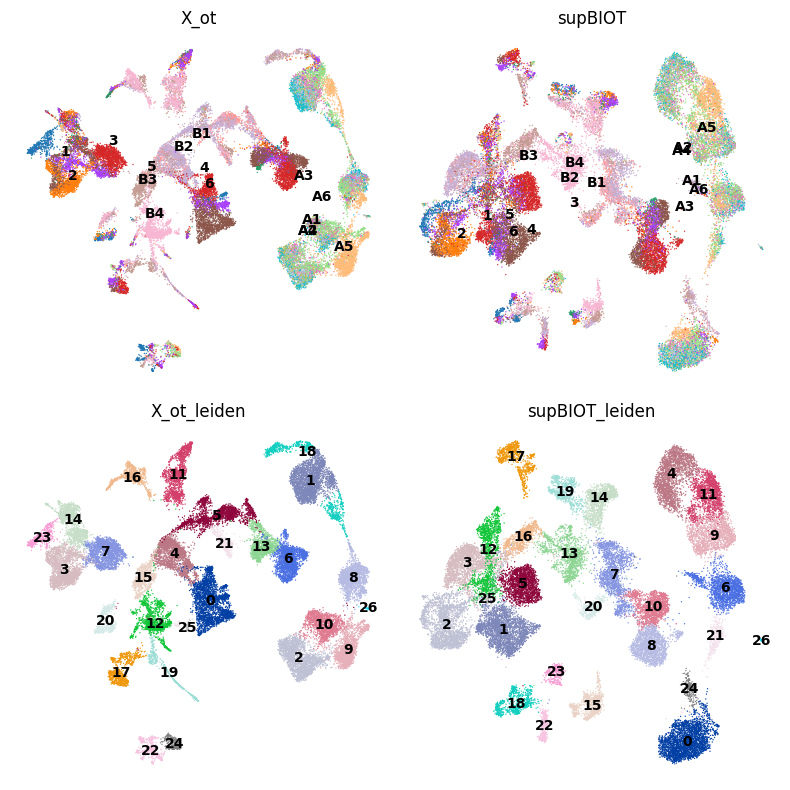

In [17]:
import matplotlib.pyplot as plt
import scanpy as sc


# 2 rows x len(methods) columns
fig, axes = plt.subplots(
    2,
    len(methods),
    figsize=(4 * len(methods), 8),
    squeeze=False  # ensures axes is a 2D array
)

for col, method in enumerate(methods):
    # 1) Top row (row=0): color by "batch"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",  # The coordinates stored in adata.obsm["X_umap_{method}"]
        color="batch",            # Assume adata.obs["batch"] exists
        frameon=False,
        ax=axes[0, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        title=f"{method}"
    )

    # 2) Bottom row (row=1): color by the Leiden clusters for this method
    leiden_key = f"{method}_leiden"
    sc.pl.embedding(
        adata,
        basis=f"X_umap_{method}",
        color=leiden_key,         # Column in adata.obs
        frameon=False,
        ax=axes[1, col],
        show=False,
        legend_loc="on data",
        legend_fontsize=10,  # smaller font
        # title=f"{method}"
    )

plt.tight_layout()
# fig.savefig("batch_and_leiden_per_embedding.pdf", dpi=300)
# plt.close(fig)


In [18]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'semi_cell_type', 'n_counts', 'leiden_X_ot', 'X_ot_leiden', 'supBIOT_leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_X_ot', '_scbiot_setup', 'X_ot_leiden', 'supBIOT_leiden', 'batch_colors', 'X_ot_leiden_colors', 'supBIOT_leiden_colors'
    obsm: 'X_pca', 'X_ot', 'X_umap', 'supBIOT', 'X_umap_X_ot', 'X_umap_supBIOT'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [19]:
# fix the bug in the scib-metrics
# change _graph_connectivity.py: <mask = labels == label> to <mask = (labels == label).to_numpy()> 



In [20]:
# # %pip install scvi-tools
# import scvi
# torch.set_float32_matmul_precision("high")

# scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
# vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
# vae.train()
# adata.obsm["scVI"] = vae.get_latent_representation()

# lvae = scvi.model.SCANVI.from_scvi_model(
#     vae,
#     adata=adata,
#     labels_key="semi_cell_type",
#     unlabeled_category="Unknown",
#     linear_classifier=True,
# )
# lvae.train(max_epochs=100)
# adata.obsm["scANVI"] = lvae.get_latent_representation()

In [21]:
bm = Benchmarker(
    adata, 
    batch_key="batch",
    label_key="cell_type",
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),    
    embedding_obsm_keys=["X_pca", "X_ot","supBIOT"], # , "scANVI"
    n_jobs=-1
    
)
bm.benchmark()

Embeddings: 100%|██████████| 3/3 [01:31<00:00, 30.54s/it]


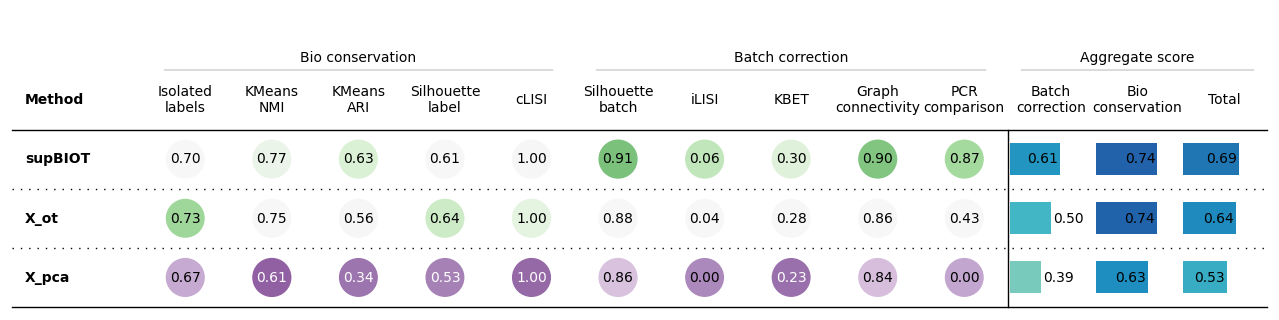

In [22]:
bm.plot_results_table(min_max_scale=False)